# Data Assesing 

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tools import*
# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';')

/home/shapiro/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Lets see the shape of our dataframes first

In [3]:
print("Population contains {} with {} feature".format(azdias.shape[0],azdias.shape[1]))

Population contains 891221 with 366 feature


In [4]:
print("Costumers contains {} with {} feature".format(customers.shape[0],customers.shape[1]))

Costumers contains 191652 with 369 feature


We can see from above that customers contains 3 more features than the population , let's check them out 

In [5]:
customers_spec_cols=set(customers.columns) - set(azdias.columns)
customers_spec_cols #specific columns only for customers

{'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'}

It makes sense , since they're already customers they should have some features with respect to the company 

In [6]:
#loading the description excel sheet
# here we are making a multi index of of the value and the name of the column 
description_full = pd.read_excel("DIAS Attributes - Values 2017.xlsx",sheet_name="Tabelle1",header=1,index_col=[1],keep_default_na=False)
desc=description_full.copy()

### Let's take a look at the missing values in both data sets 

Looking at missing values in both the population and the customers data may give us some intuition about data that company may consider valuable to save about the customer

But we have a problem we should solve first, according to the excel sheet that describing the features of both data sets , we can see that missing values in some columns are encoding as either 0 , -1 not NaN , so we should construct of a dictionary containg the column name as a key and value as missing value encoding

For example , if column `x` in both the customers and population dataset is missing more than of 80% of it's values it doesn't seem to be important

In [7]:
desc=desc[desc.Meaning.str.match('unknown')] # now we filtered to only values who has the word known/unkown is it's meaning 
desc

,Unnamed: 0,Description,Value,Meaning
Attribute,,,,
AGER_TYP,,best-ager typology,-1,unknown
ALTERSKATEGORIE_GROB,,age classification through prename analysis,"-1, 0",unknown
ALTER_HH,,main age within the household,0,unknown / no main age detectable
ANREDE_KZ,,gender,"-1, 0",unknown
BALLRAUM,,distance to next urban centre,-1,unknown
...,...,...,...,...
WOHNDAUER_2008,,length of residence,"-1, 0",unknown
WOHNLAGE,,residential-area,-1,unknown
WACHSTUMSGEBIET_NB,,growing area (population growth in the last 5 ...,"-1, 0",unknown


We can see 294 rows with 294 attributes and thier missing values , but let's do further checking to see if thier any duplicate values 

In [8]:
desc.Meaning.value_counts() 

unknown                             232
unknown / no main age detectable      1
Name: Meaning, dtype: int64

As we can see above the all of the meanings refere that there's actually missing value , whether its unmeasurable or people refused to respond or even don't have it

So let's make our dictionary 

In [9]:
uk_encodings=desc.reset_index().set_index('Attribute')['Value'].to_dict() #getting the encodings

In [10]:
len(uk_encodings)

233

In [11]:
azdias.isna().sum().sum()

33492923

Let's apply them to the data set 

In [12]:
for col in azdias.columns:
    if col in uk_encodings.keys():
        azdias[col].replace(uk_encodings.get(col),np.nan,inplace=True)

In [13]:
azdias.isna().sum().sum()

34740782

As we can see above the value of the NaN increase by approximatly 13,000

In [14]:
import gc #garbage collector for memory 
gc.enable() 
gc.collect() 

2445

In [15]:
import pickle as pk 
pk.dump(uk_encodings,open("Uknown_Encodings.pkl","wb")) #for later loading in the testing and training data set 

Let's do this to the customers dataframe as well 

In [16]:
cust_nan_before=customers.isna().sum().sum()
for col in customers.columns:
    if col in uk_encodings.keys():
        customers[col].replace(uk_encodings.get(col),np.nan,inplace=True)
        
cust_nan_after=customers.isna().sum().sum()

print("Before {} , After {}".format(cust_nan_before,cust_nan_after))

cust_nan_after=cust_nan_before=None

Before 13864522 , After 14125750


## Instead of Explicit NaNs , we may have some outliers in ourdata set

In [17]:
different_columns_union=list(set(set(azdias.columns)-(set(description_full.index))).union(set(description_full.index)-(set(azdias.columns))))
len(different_columns_union)

136

In [18]:
different_columns_azdias=set(set(azdias.columns)-(set(description_full.index)))
len(different_columns_azdias)

94

We can see from above that we have **94** feature in azdias that are not in the description sheet
and **136** feature in total that are in azdias and not in description or vice versa

Due to above , we will only work with the intersection between both to identify potential outliers

In [19]:
inter_cols=list(set(azdias.columns).intersection(set(description_full.index)))
len(inter_cols)

272

Since the above columns are'nt mentioned in the information dataset , the final decision of whether to drop them or not will be according to the percentage of thier missing values so we can check them later

In [25]:
nan_df=summarize_columns(different_columns_azdias,azdias,return_nan_df=True)

Column UMFELD_JUNG
Values that cannot be parsed to Float []
NaNs = 97786
Sample of values = [4.0, 3.0, 5.0, 2.0, 1.0]
Propotion  of NaNs = 0.10972138223852446
Column RT_KEIN_ANREIZ
Values that cannot be parsed to Float []
NaNs = 4854
Sample of values = [4.0, 2.0, 5.0, 3.0, 1.0]
Propotion  of NaNs = 0.005446460529992
Column D19_RATGEBER
Values that cannot be parsed to Float []
NaNs = 0
Sample of values = [4, 3, 6, 7, 1]
Propotion  of NaNs = 0.0
Column EINGEZOGENAM_HH_JAHR
Values that cannot be parsed to Float []
NaNs = 73499
Sample of values = [2011.0, 2017.0, 2005.0, 2014.0, 2003.0]
Propotion  of NaNs = 0.08247000463409188
Column D19_SCHUHE
Values that cannot be parsed to Float []
NaNs = 0
Sample of values = [2, 6, 3, 0, 7]
Propotion  of NaNs = 0.0
Column D19_WEIN_FEINKOST
Values that cannot be parsed to Float []
NaNs = 0
Sample of values = [4, 5, 0, 3, 1]
Propotion  of NaNs = 0.0
Column D19_HAUS_DEKO
Values that cannot be parsed to Float []
NaNs = 0
Sample of values = [1, 7, 3, 0, 5]


In [26]:
nan_df.sort_values(by="Nan_prop",ascending=False,inplace=True)
nan_df[nan_df.Nan_prop >= 0.5]

,Nan_prop
ALTER_KIND4,0.998648
ALTER_KIND3,0.993077
ALTER_KIND2,0.966900
ALTER_KIND1,0.909048
EXTSEL992,0.733996
KK_KUNDENTYP,0.655967


Those will be droped later , but let's first check the rest 

In [27]:
description_full.head()

,Unnamed: 0,Description,Value,Meaning
Attribute,,,,
AGER_TYP,,best-ager typology,-1,unknown
AGER_TYP,,,0,no classification possible
AGER_TYP,,,1,passive elderly
AGER_TYP,,,2,cultural elderly
AGER_TYP,,,3,experience-driven elderly


In [28]:
values_dict={}
broken=[]
for col in set(inter_cols):
    try:
        
        values_dict[col]=list(description_full[~description_full.Meaning.str.match('unknown')].loc[col,"Value"].values)
    
    except:
        print("Broke at {}".format(col))
        broken.append(col)

Broke at ANZ_TITEL
Broke at GEBURTSJAHR
Broke at MIN_GEBAEUDEJAHR
Broke at ANZ_HH_TITEL
Broke at ANZ_PERSONEN
Broke at KBA13_ANZAHL_PKW
Broke at ANZ_HAUSHALTE_AKTIV


In [29]:
description_full.loc[broken,:]

,Unnamed: 0,Description,Value,Meaning
Attribute,,,,
ANZ_TITEL,,number of professional title holder in household,…,numeric value (typically coded from 1-10)
GEBURTSJAHR,,year of birth,…,numeric value
MIN_GEBAEUDEJAHR,,year the building was first mentioned in our d...,…,numeric value
ANZ_HH_TITEL,,number of academic title holder in building,…,numeric value (typically coded from 1-10)
ANZ_PERSONEN,,number of adult persons in the household,…,numeric value (typically coded from 1-3)
KBA13_ANZAHL_PKW,,number of cars in the PLZ8,…,numeric value
ANZ_HAUSHALTE_AKTIV,,number of households in the building,…,numeric value (typically coded from 1-10)


In [30]:
for i in broken:
    inter_cols.remove(i)

We can see that the columns we couldn't identify thier values are all numerical 

In [31]:
values_dict

{'KBA05_MOD8': [0, 1, 2, 3],
 'KBA13_CCM_2000': [0, 1, 2, 3, 4, 5],
 'TITEL_KZ': [1, 2, 3, 4, 5],
 'KBA13_SEG_GELAENDEWAGEN': [0, 1, 2, 3, 4, 5],
 'ONLINE_AFFINITAET': [0, 1, 2, 3, 4, 5],
 'KBA13_HALTER_45': [0, 1, 2, 3, 4, 5],
 'KBA13_SEG_VAN': [0, 1, 2, 3, 4, 5],
 'KBA05_SEG6': [0, 1],
 'KBA13_SEG_MINIWAGEN': [0, 1, 2, 3, 4, 5],
 'FINANZ_UNAUFFAELLIGER': [1, 2, 3, 4, 5],
 'FINANZTYP': [1, 2, 3, 4, 5, 6],
 'FINANZ_MINIMALIST': [1, 2, 3, 4, 5],
 'KBA13_HALTER_30': [0, 1, 2, 3, 4, 5],
 'SEMIO_PFLICHT': [1, 2, 3, 4, 5, 6, 7],
 'D19_TELKO_ONLINE_DATUM': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'KBA05_KRSHERST3': [1, 2, 3, 4, 5],
 'KBA13_HALTER_25': [0, 1, 2, 3, 4, 5],
 'KBA13_SITZE_6': [0, 1, 2, 3, 4, 5],
 'KBA05_ZUL1': [1, 2, 3, 4, 5],
 'SEMIO_MAT': [1, 2, 3, 4, 5, 6, 7],
 'KBA13_KW_110': [0, 1, 2, 3, 4, 5],
 'D19_VERSAND_DATUM': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'KBA05_MOD3': [1, 2, 3, 4, 5],
 'KBA13_SEG_OBEREMITTELKLASSE': [0, 1, 2, 3, 4, 5],
 'KBA05_MOD4': [0, 1, 2, 3, 4, 5],
 'KBA05_SEG5': 

In [32]:
pk.dump(values_dict,open("Values_dictionary.pkl","wb")) #for later use

In [33]:
set(azdias.KBA05_MOD3.value_counts().index).difference(set(values_dict['KBA05_MOD3']))

{9.0}

In [34]:
before=azdias.isna().sum().sum()
before

34740782

In [35]:
all(item in values_dict for item in inter_cols)

True

In [36]:
for col in inter_cols:
    
    values=list(set(azdias[col].value_counts().index).difference(set(values_dict[col])))
    
    if len(values) >1 :
        
        for value in values:
            azdias[col].replace(value,np.nan,inplace=True)
    else:
        
        azdias[col].replace(values,np.nan,inplace=True)
            
                

In [37]:
after=azdias.isna().sum().sum()
print("Added {} more Nans to azdias".format(after - before))
before=after=None

Added 3144445 more Nans to azdias


In [38]:
for col in inter_cols:
    
    values=list(set(customers[col].value_counts().index).difference(set(values_dict[col])))
    
    if len(values) >1 :
        
        for value in values:
            customers[col].replace(value,np.nan,inplace=True)
    else:
        
        customers[col].replace(values,np.nan,inplace=True)           

## **So let's take a look of the propotion of NANs in each column and how they're distributed accross both the DataSets**

Let's first make a slice of the customers data frame without the columns that belongs to the company 

In [39]:
cols_to_keep = list(set(customers.columns).intersection(set(azdias.columns))) #getting the intersection between the columns of customers and the population 
len(cols_to_keep)

366

In [40]:
cust_slic=customers[cols_to_keep]

In [41]:
#creating a series for nans and thier propotions in the azdias dataframe
nans_azdias=azdias.isna().sum()/azdias.shape[0]
#creating a series for nans and thier propotions in the customers dataframe
nans_cust=cust_slic.isna().sum()/cust_slic.shape[0]
#naming both serieses for merging
nans_azdias.name="Population"
nans_cust.name="Customers"

In [42]:
len(nans_azdias),len(nans_cust)

(366, 366)

In [43]:
#merging on the index (feature names)
feature_nans=pd.merge(nans_azdias,nans_cust,left_index=True,right_index=True)
#making the index as a column to ease plotting 
feature_nans=feature_nans.reset_index().rename(columns={"index":"Feature"})
#sorting for the order of the plot 
feature_nans.sort_values(by=["Customers","Population"],ascending=False,inplace=True)
feature_nans.reset_index(inplace=True,drop=True)
feature_nans=feature_nans.melt(id_vars=['Feature'],var_name="Class",value_name="Propotion")
feature_nans

,Feature,Class,Propotion
0,ALTER_KIND4,Population,0.998648
1,ALTER_KIND3,Population,0.993077
2,TITEL_KZ,Population,0.997576
3,ALTER_KIND2,Population,0.966900
4,ALTER_KIND1,Population,0.909048
...,...,...,...
727,SEMIO_TRADV,Customers,0.000000
728,SEMIO_VERT,Customers,0.000000
729,ZABEOTYP,Customers,0.000000
730,ANREDE_KZ,Customers,0.000000


Let's select only columns with more than 50% missing values, as it seams not the important to be included since it's missing that much data 

In [44]:
threshold=0.5
removed_cols=list(set(feature_nans[~(feature_nans.Propotion < threshold)].Feature.values))
removed_cols

['TITEL_KZ',
 'ALTER_KIND1',
 'ALTER_KIND3',
 'AGER_TYP',
 'ALTER_KIND4',
 'KBA05_BAUMAX',
 'KK_KUNDENTYP',
 'ALTER_KIND2',
 'CAMEO_DEUG_2015',
 'EXTSEL992']

In [45]:
feature_nans=feature_nans[feature_nans.Propotion < threshold]
feature_nans.sort_values(by="Propotion",ascending=False)

,Feature,Class,Propotion
374,AGER_TYP,Customers,0.480595
375,EXTSEL992,Customers,0.444989
376,ALTER_HH,Customers,0.358707
10,ALTER_HH,Population,0.348137
377,KKK,Customers,0.313401
...,...,...,...
339,FINANZ_ANLEGER,Population,0.000000
340,FINANZ_HAUSBAUER,Population,0.000000
341,FINANZ_MINIMALIST,Population,0.000000
342,FINANZ_SPARER,Population,0.000000


In [46]:
len(set(feature_nans.Feature))

358

In [47]:
cols_to_keep=list(set(feature_nans.Feature.values))
len(cols_to_keep)

358

In [48]:
set(removed_cols).intersection(set(cols_to_keep))

{'AGER_TYP', 'EXTSEL992'}

========================================================================================

In [49]:
save_list(cols_to_keep,"cols_to_keep")
save_list(removed_cols,"cols_removed")

In [50]:
azdias.to_csv("azdias_ver1.csv",index=False)

In [51]:
customers.to_csv("customers_ver1.csv",index=False)

### Now we should restart kernel for memory shortage 

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tools import*
# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
cols_to_keep=load_list("cols_to_keep")
removed_cols=load_list("cols_removed")
azdias=pd.read_csv("azdias_ver1.csv")
customers=pd.read_csv("customers_ver1.csv")

/home/shapiro/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


======================================================================================

In [3]:
azdias=azdias[cols_to_keep]
customers=customers[cols_to_keep]

We can see that we dropped 10 non important columns , so we still have 358 attributes with missing values

In [4]:
removed_cols

['TITEL_KZ',
 'KBA05_BAUMAX',
 'CAMEO_DEUG_2015',
 'AGER_TYP',
 'KK_KUNDENTYP',
 'EXTSEL992',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'ALTER_KIND2',
 'ALTER_KIND1']

For a categorical value we can replace with median , and for numeric variables we can replace with mean 

In [5]:
#loading the description excel sheet
# here we are making a multi index of of the value and the name of the column 
description_full = pd.read_excel("DIAS Attributes - Values 2017.xlsx",sheet_name="Tabelle1",header=1,index_col=[1],keep_default_na=False)

In [6]:
#Knowing which has a numerical or catgorical variable from the description csv file
numeric=list(description_full[description_full.Meaning.str.match('.*numeric.*')].index)
numeric=set(numeric) - set(removed_cols)
numeric

{'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'GEBURTSJAHR',
 'KBA13_ANZAHL_PKW',
 'MIN_GEBAEUDEJAHR'}

In [7]:
#categorical 
categorical=list(set(azdias.columns) - set(numeric))

In [8]:
len(numeric) + len(categorical)

358

Let's do further exploration to see if we missed any string columns that cannot be passed to imputer instance

In [9]:
# Before casting to float we should first fill NAs with any temporary value to make it possible to cast since we cannot do any operation with nans 
string_cols_cust=set()
string_cols_azd=set()
#iterating over the customers columns 
for col in customers.columns:
    
    try :
        customers[col].fillna(0).astype(float)
    except:
        print("Couldn't convert {} column in customers".format(col))
        string_cols_cust.add(col)

#another iteration in the azdias column since maybe there will be an entry error in azdias but not in customers        
for col in azdias.columns:
    try :
        azdias[col].fillna(0,).astype(float)
    except:
        print("Couldn't convert {} column in azdias ".format(col))
        string_cols_azd.add(col)

Couldn't convert EINGEFUEGT_AM column in customers
Couldn't convert CAMEO_INTL_2015 column in customers
Couldn't convert CAMEO_DEU_2015 column in customers
Couldn't convert D19_LETZTER_KAUF_BRANCHE column in customers
Couldn't convert OST_WEST_KZ column in customers
Couldn't convert EINGEFUEGT_AM column in azdias 
Couldn't convert CAMEO_INTL_2015 column in azdias 
Couldn't convert CAMEO_DEU_2015 column in azdias 
Couldn't convert D19_LETZTER_KAUF_BRANCHE column in azdias 
Couldn't convert OST_WEST_KZ column in azdias 


Lets compare both sets 

In [10]:
len(string_cols_azd),len(string_cols_cust)

(5, 5)

Let's Manually Check those columns 

**Checking in Customers Dataframe**

In [11]:
summarize_columns(string_cols_cust,customers)

Column OST_WEST_KZ
Values that cannot be parsed to Float ['O', 'W']
NaNs = 49927
Sample of values = ['W', 'O']
Propotion  of NaNs = 0.26050863022561727
Column CAMEO_DEU_2015
Values that cannot be parsed to Float ['3D', '4B', '5C', '4C', '7A', '8A', '5A', '2D', '9D', '8D']
NaNs = 50554
Sample of values = ['6D', '8C']
Propotion  of NaNs = 0.2637801849184981
Column D19_LETZTER_KAUF_BRANCHE
Values that cannot be parsed to Float ['D19_HANDWERK', 'D19_SONSTIGE', 'D19_DROGERIEARTIKEL', 'D19_KINDERARTIKEL', 'D19_UNBEKANNT', 'D19_LEBENSMITTEL', 'D19_VOLLSORTIMENT', 'D19_DIGIT_SERV', 'D19_SAMMELARTIKEL', 'D19_TELKO_MOBILE']
NaNs = 47697
Sample of values = ['D19_BUCH_CD', 'D19_SONSTIGE']
Propotion  of NaNs = 0.24887295723498842
Column EINGEFUEGT_AM
Values that cannot be parsed to Float ['1998-07-01 00:00:00', '2001-08-15 00:00:00', '2009-07-29 00:00:00', '2005-04-22 00:00:00', '2002-05-02 00:00:00', '2013-12-12 00:00:00', '2009-04-06 00:00:00', '2000-11-27 00:00:00', '2013-02-04 00:00:00', '2008-

- Tt's more appropriate  to drop `EINGEFUEGT_AM` since it have dates and it will be inconsistent to impute the median date, also it's missing more than 26% of it's values
- Some NaNs in `CAMEO_INTL_2015` and `CAMEO_DEU_2015` are encoded with "XX" ( Should be Changed to np.nan )

**Checking in Customers Dataframe**

In [12]:
string_cols_azd.remove("EINGEFUEGT_AM")
string_cols_cust.remove("EINGEFUEGT_AM")
categorical.remove("EINGEFUEGT_AM")
customers.drop(columns="EINGEFUEGT_AM",inplace=True)
azdias.drop(columns="EINGEFUEGT_AM",inplace=True)

In [13]:
customers.CAMEO_INTL_2015.replace("XX",np.nan,inplace=True)
azdias.CAMEO_INTL_2015.replace("XX",np.nan,inplace=True)
customers.CAMEO_DEU_2015.replace("XX",np.nan,inplace=True)
azdias.CAMEO_DEU_2015.replace("XX",np.nan,inplace=True)

**Checking in Azdias Dataframe**

In [15]:
summarize_columns(string_cols_azd,azdias)
    

Column OST_WEST_KZ
Values that cannot be parsed to Float ['O', 'W']
NaNs = 93148
Sample of values = ['W', 'O']
Propotion  of NaNs = 0.10451728583594866
Column CAMEO_DEU_2015
Values that cannot be parsed to Float ['3D', '5C', '4B', '4C', '7A', '8A', '5A', '2D', '9D', '8D']
NaNs = 99352
Sample of values = ['6D', '5F']
Propotion  of NaNs = 0.11147852216229195
Column D19_LETZTER_KAUF_BRANCHE
Values that cannot be parsed to Float ['D19_HANDWERK', 'D19_SONSTIGE', 'D19_DROGERIEARTIKEL', 'D19_KINDERARTIKEL', 'D19_UNBEKANNT', 'D19_VOLLSORTIMENT', 'D19_LEBENSMITTEL', 'D19_DIGIT_SERV', 'D19_SAMMELARTIKEL', 'D19_TELKO_MOBILE']
NaNs = 257113
Sample of values = ['D19_KINDERARTIKEL', 'D19_BIO_OEKO']
Propotion  of NaNs = 0.2884952217239046
Column CAMEO_INTL_2015
Values that cannot be parsed to Float []
NaNs = 99352
Sample of values = [24.0, 55.0]
Propotion  of NaNs = 0.11147852216229195


In [16]:
len(numeric)+ len(categorical)

357

In [17]:
azdias.shape[1],customers.shape[1]

(357, 357)

Checking the categorical 

In [18]:
summarize_columns(categorical,customers,only_uncasted=True,samples=20)

Column OST_WEST_KZ
Values that cannot be parsed ['O', 'W']
NaNs = 49927
Sample of values = ['W' 'W' 'W' 'W' 'W' 'O' 'W' 'W' 'W' 'W' 'W' 'W' 'W' 'W' 'W' 'W' 'W' 'W'
 'O' 'W']
Propotion  of NaNs = 0.26050863022561727
Column CAMEO_DEU_2015
Values that cannot be parsed ['3D', '4B', '5C', '4C', '7A', '8A', '5A', '2D', '9D', '8D']
NaNs = 50554
Sample of values = ['5D' '8A' '1D' '2D' '9A' '2D' '4A' '3D' '3B' '4C' '2C' '4C' '4C' '2D'
 '9E' '4D' '5A' '3D' '3D' '4A']
Propotion  of NaNs = 0.2637801849184981
Column D19_LETZTER_KAUF_BRANCHE
Values that cannot be parsed ['D19_HANDWERK', 'D19_SONSTIGE', 'D19_DROGERIEARTIKEL', 'D19_KINDERARTIKEL', 'D19_UNBEKANNT', 'D19_LEBENSMITTEL', 'D19_VOLLSORTIMENT', 'D19_DIGIT_SERV', 'D19_SAMMELARTIKEL', 'D19_TELKO_MOBILE']
NaNs = 47697
Sample of values = ['D19_SONSTIGE' 'D19_DROGERIEARTIKEL' 'D19_BEKLEIDUNG_GEH'
 'D19_BEKLEIDUNG_REST' 'D19_BEKLEIDUNG_GEH' 'D19_BUCH_CD' 'D19_FREIZEIT'
 'D19_BUCH_CD' 'D19_UNBEKANNT' 'D19_VERSICHERUNGEN' 'D19_BEKLEIDUNG_GEH'
 'D19_

In [19]:
save_list(string_cols_azd,"string_cols_azd")
save_list(string_cols_cust,"string_cols_cust")
save_list(categorical,"cat1")
save_list(numeric,"num1")
#load numeric and categorical after
azdias.to_csv("azdias_ver2.csv",index=False)
customers.to_csv("customers_ver2.csv",index=False)

In [20]:
azdias.shape,azdias.dropna().shape

((891221, 357), (77283, 357))

In [21]:
customers.shape,customers.dropna().shape

((191652, 357), (60136, 357))

### Now Restarting Kernel 

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tools import*
# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
string_cols_azd=load_list("string_cols_azd")
string_cols_cust=load_list("string_cols_cust")
categorical=load_list("cat1")
numeric=load_list("num1")
azdias=pd.read_csv("azdias_ver2.csv")
customers=pd.read_csv("customers_ver2.csv")

==============================================

In [3]:
from sklearn.linear_model import BayesianRidge
num_estimator=BayesianRidge()

In [4]:
string_cols_azd

{'CAMEO_DEU_2015', 'OST_WEST_KZ'}

In [5]:
string_cols_cust

{'CAMEO_DEU_2015', 'OST_WEST_KZ'}

Those above columns needs to be encoded before imputing them , but let's first check thier meaning to select and apropiate encoder whether ordinal or label 

In [6]:
#loading the description excel sheet
# here we are making a multi index of of the value and the name of the column 
description_full = pd.read_excel("DIAS Attributes - Values 2017.xlsx",sheet_name="Tabelle1",header=1,index_col=[1],keep_default_na=False)

In [7]:
explainable=set(description_full.index).intersection(string_cols_azd)
print(explainable)
for i in explainable:
    print(description_full.loc[i,"Description"].values[0])

{'CAMEO_DEU_2015', 'OST_WEST_KZ'}
CAMEO classification 2015 - detailled classification
flag indicating the former GDR/FRG


In [8]:
summarize_columns(['CAMEO_INTL_2015','D19_LETZTER_KAUF_BRANCHE',"CAMEO_DEU_2015","OST_WEST_KZ"],azdias)

Column CAMEO_INTL_2015
Values that cannot be parsed to Float []
NaNs = 99352
Sample of values = [12.0, 35.0, 51.0, 22.0, 23.0]
Propotion  of NaNs = 0.11147852216229195
Column D19_LETZTER_KAUF_BRANCHE
Values that cannot be parsed to Float ['D19_KINDERARTIKEL', 'D19_NAHRUNGSERGAENZUNG', 'D19_UNBEKANNT', 'D19_SCHUHE', 'D19_VERSAND_REST', 'D19_HAUS_DEKO', 'D19_BEKLEIDUNG_REST', 'D19_DROGERIEARTIKEL', 'D19_GARTEN', 'D19_REISEN']
NaNs = 257113
Sample of values = ['D19_NAHRUNGSERGAENZUNG', 'D19_FREIZEIT', 'D19_WEIN_FEINKOST', 'D19_BANKEN_DIREKT', 'D19_HAUS_DEKO']
Propotion  of NaNs = 0.2884952217239046
Column CAMEO_DEU_2015
Values that cannot be parsed to Float ['4B', '1D', '7D', '1B', '7A', '8B', '6F', '2B', '5A', '4D']
NaNs = 99352
Sample of values = ['1D', '9C', '5F', '6B', '2B']
Propotion  of NaNs = 0.11147852216229195
Column OST_WEST_KZ
Values that cannot be parsed to Float ['W', 'O']
NaNs = 93148
Sample of values = ['O', 'W']
Propotion  of NaNs = 0.10451728583594866


We can see from above that CAMEO_INTL_2015 is now a numerical column after removing unknown encoding of 'XX' from it. 

In [11]:
numeric.add("CAMEO_INTL_2015")
categorical.remove("CAMEO_INTL_2015")
save_list(numeric,"num1")
save_list(categorical,"cat1")
string_cols_azd.remove("CAMEO_INTL_2015")
string_cols_cust.remove("CAMEO_INTL_2015")
save_list(string_cols_azd,"string_cols_azd")
save_list(string_cols_azd,"string_cols_cust")

In [12]:
summarize_columns(string_cols_azd,azdias)

Column CAMEO_DEU_2015
Values that cannot be parsed to Float ['4B', '1D', '7D', '1B', '7A', '8B', '6F', '2B', '5A', '4D']
NaNs = 99352
Sample of values = ['5E', '5C', '9A', '9B', '2C']
Propotion  of NaNs = 0.11147852216229195
Column OST_WEST_KZ
Values that cannot be parsed to Float ['W', 'O']
NaNs = 93148
Sample of values = ['O', 'W']
Propotion  of NaNs = 0.10451728583594866


In [13]:
summarize_columns(string_cols_cust,customers)

Column CAMEO_DEU_2015
Values that cannot be parsed to Float ['4B', '1D', '7D', '1B', '7A', '8B', '6F', '2B', '5A', '4D']
NaNs = 50554
Sample of values = ['7B', '8A', '4A', '8D', '3D']
Propotion  of NaNs = 0.2637801849184981
Column OST_WEST_KZ
Values that cannot be parsed to Float ['W', 'O']
NaNs = 49927
Sample of values = ['O', 'W']
Propotion  of NaNs = 0.26050863022561727


We can remove the D19_LETZTER_KAUF_BRANCHE column because it's just a comination of other columns name and also 25% of it's values are missing and it's not a small ratio.

In [14]:
azdias.drop(columns="D19_LETZTER_KAUF_BRANCHE",inplace=True)
customers.drop(columns="D19_LETZTER_KAUF_BRANCHE",inplace=True)

In [15]:
categorical.remove("D19_LETZTER_KAUF_BRANCHE")
save_list(numeric,"num1")
save_list(categorical,"cat1")
string_cols_azd.remove("D19_LETZTER_KAUF_BRANCHE")
string_cols_cust.remove("D19_LETZTER_KAUF_BRANCHE")
save_list(string_cols_azd,"string_cols_azd")
save_list(string_cols_azd,"string_cols_cust")

Now we can see we're only left with two string categorical columns , which are `OST_WEST_KZ` and `CAMEO_DEU_2015`

As we saw above , we can encode them ordinaly to impute thier missing values , and after then we will decode them and one hot encode them later on

But column `OST_WEST_KZ` encodes are easy and don't need a OrdinalEncoder for them since they've only two levels. 
'W' , 'O'. 
- 'W' will be 1
- 'O' will be 0

In [14]:
azdias.OST_WEST_KZ.replace("W",1,inplace=True)
azdias.OST_WEST_KZ.replace("O",0,inplace=True)
customers.OST_WEST_KZ.replace("W",1,inplace=True)
customers.OST_WEST_KZ.replace("O",0,inplace=True)

In [15]:
from sklearn.preprocessing import OrdinalEncoder

In [16]:
encoder=OrdinalEncoder()

We have replace NANS first for the ordinal to be fitted

In [17]:
azdias.CAMEO_DEU_2015.replace(np.nan,"NULL",inplace=True)
customers.CAMEO_DEU_2015.replace(np.nan,"NULL",inplace=True)

In [18]:
encoder.fit(azdias.CAMEO_DEU_2015.values.reshape(-1,1))

OrdinalEncoder()

In [19]:
encoder.transform(np.array("NULL").reshape(1,-1))

array([[44.]])

we can see that NULL has the value of 44 , let's keep that in mind to change it back again to nan 

In [20]:
azdias.CAMEO_DEU_2015.values.reshape(-1,1)

array([['NULL'],
       ['8A'],
       ['4C'],
       ...,
       ['4C'],
       ['9D'],
       ['6B']], dtype=object)

In [21]:
new_CAMEO_DEU_2015_azd=encoder.transform(azdias.CAMEO_DEU_2015.values.reshape(-1,1)).squeeze()
new_CAMEO_DEU_2015_azd


array([44., 35., 15., ..., 15., 42., 25.])

In [22]:
customers.CAMEO_DEU_2015.values.reshape(-1,1)

array([['1A'],
       ['NULL'],
       ['5D'],
       ...,
       ['4D'],
       ['4C'],
       ['5C']], dtype=object)

In [23]:
new_CAMEO_DEU_2015_cust=encoder.transform(customers.CAMEO_DEU_2015.values.reshape(-1,1)).squeeze()
new_CAMEO_DEU_2015_cust

array([ 0., 44., 21., ..., 16., 15., 20.])

In [24]:
azdias.loc[:,"CAMEO_DEU_2015"]=new_CAMEO_DEU_2015_azd
customers.loc[:,"CAMEO_DEU_2015"]=new_CAMEO_DEU_2015_cust

In [25]:
azdias.CAMEO_DEU_2015.isna().sum(),customers.CAMEO_DEU_2015.isna().sum()

(0, 0)

In [26]:
azdias.CAMEO_DEU_2015.replace(44,np.nan,inplace=True)
customers.CAMEO_DEU_2015.replace(44,np.nan,inplace=True)

In [27]:
azdias.CAMEO_DEU_2015.isna().sum(),customers.CAMEO_DEU_2015.isna().sum()

(99352, 50554)

In [28]:
import pickle as pk 

In [29]:
pk.dump(encoder,open("CAMEO_DEU_2015_ENC.pkl","wb"))

In [30]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
estimator=BayesianRidge()

In [31]:
imp_mean=IterativeImputer(estimator=estimator,initial_strategy="mean",missing_values=np.nan)  #mean imputer for numeric values 
imp_mode=IterativeImputer(estimator=estimator,initial_strategy="most_frequent",missing_values=np.nan) #mode imputer for categorical variable

Before imputing NaNs lets change string categorical variables to strings

In [32]:
customers.loc[:,string_cols_cust]=customers[string_cols_cust].astype(str).replace("nan",np.nan)
azdias.loc[:,string_cols_azd]=azdias[string_cols_azd].astype(str).replace("nan",np.nan)

And now for the imputing step , since our dataset has a lot of observations and a lot of columns , we will first impute the NaNs in the numeric columns at once , after that we will impute those for categorical columns but taking 10% of columns at a time for 10 times for our memory to withstand this expensive calculations 

In [33]:
cust_nan_before=customers.isna().sum().sum() #calculating missing values in customers dataframe before imputing 
azd_nan_before=azdias.isna().sum().sum() #calculating missing values in Azdias dataframe before imputing 

customers.loc[:,numeric]=imp_mean.fit_transform(customers[numeric])

azdias.loc[:,numeric]=imp_mean.fit_transform(azdias[numeric])

cust_nan_after_numeric=customers.isna().sum().sum() #calculating missing values in customers dataframe After imputing 
azd_nan_after_numeric=azdias.isna().sum().sum() #calculating missing values in Azdias dataframe After imputing 
print("Customers NaNs , Before {} , After Numeric NaNs imputing {}".format(cust_nan_before,cust_nan_after_numeric))
print("Population NaNs, Before {} , After Numeric NaNs imputing {}".format(azd_nan_before,azd_nan_after_numeric))

Customers NaNs , Before 13372697 , After Numeric NaNs imputing 13025706
Population NaNs, Before 31579853 , After Numeric NaNs imputing 30944399


In [34]:
batches=[]
for x in range(0,len(categorical),20):
    batches.append(categorical[x:x+20])

In [35]:
s=0
for i in batches:
    print(len(i))


20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
8


In [36]:
%%time
for batch in batches:
    
    customers.loc[:,batch]=imp_mode.fit_transform(customers[batch])
    azdias.loc[:,batch]=imp_mode.fit_transform(azdias[batch])

cust_nan_after_all=customers.isna().sum().sum() #calculating missing values in customers dataframe After imputing 
azd_nan_after_all=azdias.isna().sum().sum() #calculating missing values in Azdias dataframe After imputing 
print("Customers NaNs , Before {} , After Numeric NaNs imputing {}".format(cust_nan_before,cust_nan_after_all))
print("Population NaNs, Before {} , After Numeric NaNs imputing {}".format(azd_nan_before,azd_nan_after_all))

/home/shapiro/anaconda3/lib/python3.7/site-packages/sklearn/impute/_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/home/shapiro/anaconda3/lib/python3.7/site-packages/sklearn/impute/_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/home/shapiro/anaconda3/lib/python3.7/site-packages/sklearn/impute/_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/home/shapiro/anaconda3/lib/python3.7/site-packages/sklearn/impute/_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/home/shapiro/anaconda3/lib/python3.7/site-packages/sklearn/impute/_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)
/home/shap

Customers NaNs , Before 13372697 , After Numeric NaNs imputing 0
Population NaNs, Before 31579853 , After Numeric NaNs imputing 0
CPU times: user 4h 30min 38s, sys: 1h 28min 36s, total: 5h 59min 14s
Wall time: 41min 28s


In [41]:
azdias.to_csv("azdias_nona.csv",index=False)
customers.to_csv("customers_nona.csv",index=False)

In [37]:
customers.isna().sum().sum() 

0

In [38]:
azdias.isna().sum().sum() 

0

Now we can see that both of our datasets don't contain any NaNs 

In [17]:
def string_columns(df):
    cols=[]
    for col in df.columns:
        for value in df[col].values:
            try:
                float(value)
            except:
                cols.append(col)
                break
    return cols

In [40]:
string_cols_customers=string_columns(customers)

In [42]:
string_cols_customers

[]

In [43]:
string_cols_azdias=string_columns(azdias)

In [44]:
string_cols_azdias

[]

Now let's decode the columns we already encoded before imputing which are `CAMEO_DEU_2015` and `OST_WEST_KZ`

In [45]:
import seaborn as sns 

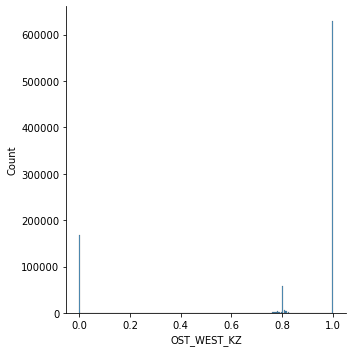

In [46]:
sns.displot(azdias.OST_WEST_KZ)

As we can see we have alot of float values , but all of them are around 0.8 , so we should ceil them up 

In [49]:
for col in categorical:
    
    max_azd=azdias.loc[:,col].max() #maximum value in column 
    azdias.loc[:,col]=azdias.loc[:,col].apply(lambda x: np.round(x) if np.round(x) <= max_azd else max_azd )
    max_cust=customers.loc[:,col].max()
    customers.loc[:,col]=customers.loc[:,col].apply(lambda x: np.round(x) if np.round(x) <= max_cust else max_cust )
    #rounding up if value is smaller than maximum ;else setting maximum if rounded value  is bigger than maximum 


In [50]:
azdias.OST_WEST_KZ.replace(1,"W",inplace=True)
azdias.OST_WEST_KZ.replace(0,"O",inplace=True)
customers.OST_WEST_KZ.replace(1,"W",inplace=True)
customers.OST_WEST_KZ.replace(0,"O",inplace=True)

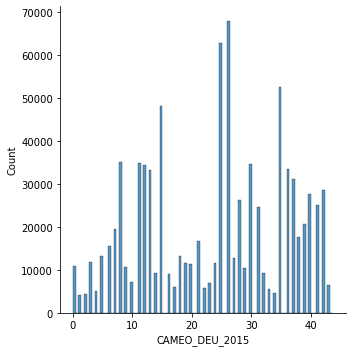

In [51]:
sns.displot(azdias.CAMEO_DEU_2015)

In [52]:
azdias.loc[:,"CAMEO_DEU_2015"]=encoder.inverse_transform(azdias.CAMEO_DEU_2015.values.reshape(-1,1)).squeeze()
customers.loc[:,"CAMEO_DEU_2015"]=encoder.inverse_transform(customers.CAMEO_DEU_2015.values.reshape(-1,1)).squeeze()

In [53]:
azdias.CAMEO_DEU_2015.value_counts()

6C    67872
6B    62839
8A    52501
4C    48121
2D    35090
3C    34849
7A    34608
3D    34420
8B    33469
4A    33289
8C    31019
9D    28596
9B    27681
6E    26334
9C    24991
7B    24671
9A    20557
2C    19430
8D    17590
5D    16827
2B    15494
2A    13250
5A    13196
6D    12801
1D    11910
6A    11553
5B    11550
5C    11398
1A    10850
3A    10566
6F    10342
4B     9239
7C     9209
4D     9047
3B     7205
5F     7006
9E     6381
4E     5984
5E     5842
7D     5460
1E     5065
7E     4731
1C     4317
1B     4071
Name: CAMEO_DEU_2015, dtype: int64

In [55]:
customers.CAMEO_DEU_2015.value_counts()

5E    46143
2D    11209
6B     9647
4C     9393
3D     8123
4A     7601
3C     6643
5D     5943
1D     5880
2C     5076
8A     4252
1A     4198
7A     4110
8B     3790
2A     3715
2B     3485
7B     3422
1E     3337
6E     3089
6C     2846
8C     2801
5A     2594
4D     2539
4B     2280
1C     2206
8D     2206
5B     2166
9D     1957
5C     1939
3A     1912
4E     1813
3B     1781
5F     1733
9E     1508
6D     1246
7C     1194
6F     1171
1B     1157
7E     1034
9A     1023
9C      987
9B      917
7D      801
6A      785
Name: CAMEO_DEU_2015, dtype: int64

In [56]:
azdias.to_csv("azdias_clean.csv",index=False)

In [57]:
customers.to_csv("customers_clean.csv",index=False)

In [58]:
save_list(azdias.columns,"Wanted_Columns")

### Cleaning the Training and Test Datasets

Since we cleaned the main datasets , we should also clean the training and testing dataset to make sure they all come from the same distribution before any further machine learning approach

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tools import*
# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
train = pd.read_csv("Udacity_MAILOUT_052018_TRAIN.csv",sep=";")

/home/shapiro/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [4]:
train.isna().sum().sum(),"Percentage : {} %".format((train.isna().sum().sum()/(train.shape[0]*train.shape[1]))*100)

(2217179, 'Percentage : 14.062100630847082 %')

We can see the more than of 14% of values are NaNs. 
<br> Let's do the exact same step we did to our Azdias and Customers datasets

1. Dropping Columns Not in Azdias and Customers. 
2. Decoding Unkown Values to NaNs using the Description sheet
3. Replacing outliers with NaNs using the value dict we computed earlier
4. Replacing "XX" in both `CAMEO_INTL_2015` and `CAMEO_DEU_2015` with NaNs 
6. Imputing both the numerical NaNs and the Categorical NaNs using both the Categorical and Numerical Columns from above in `numerical` and `categorical` objects

In [5]:
wanted_columns=list(load_list("Wanted_Columns"))
wanted_columns.append("RESPONSE") #adding the response variable to the wanted columns for training only 

In [6]:
train=train[wanted_columns]
train.shape #should be (X,517)

(42962, 357)

In [7]:
import pickle as pk 
values_dict=pk.load(open("Values_dictionary.pkl","rb"))
values_dict

{'KBA05_DIESEL': [0, 1, 2, 3, 4],
 'SEMIO_TRADV': [1, 2, 3, 4, 5, 6, 7],
 'D19_GESAMT_ANZ_12': [0, 1, 2, 3, 4, 5, 6],
 'KBA05_KRSVAN': [1, 2, 3],
 'KBA05_SEG8': [0, 1, 2, 3],
 'SEMIO_ERL': [1, 2, 3, 4, 5, 6, 7],
 'KBA05_ANTG1': [0, 1, 2, 3, 4],
 'ORTSGR_KLS9': [1, 2, 3, 4, 5, 6, 7, 8, 9],
 'KBA13_SEG_KLEINWAGEN': [0, 1, 2, 3, 4, 5],
 'HEALTH_TYP': [0, 1, 2, 3],
 'SEMIO_VERT': [1, 2, 3, 4, 5, 6, 7],
 'KBA13_SEG_KOMPAKTKLASSE': [0, 1, 2, 3, 4, 5],
 'LP_FAMILIE_FEIN': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 'KBA13_VORB_1': [0, 1, 2, 3, 4, 5],
 'KBA13_KRSSEG_OBER': [0, 1, 2, 3],
 'VERS_TYP': [1, 2],
 'PLZ8_ANTG4': [0, 1, 2],
 'SEMIO_LUST': [1, 2, 3, 4, 5, 6, 7],
 'KBA05_SEG2': [1, 2, 3, 4, 5],
 'KBA13_HERST_AUDI_VW': [0, 1, 2, 3, 4, 5],
 'KBA13_ALTERHALTER_60': [0, 1, 2, 3, 4, 5],
 'KBA05_MAXSEG': [1, 2, 3, 4],
 'KBA13_VORB_0': [0, 1, 2, 3, 4, 5],
 'KBA05_CCM3': [1, 2, 3, 4, 5],
 'KBA13_BJ_2006': [0, 1, 2, 3, 4, 5],
 'KBA13_FAB_SONSTIGE': [0, 1, 2, 3, 4, 5],
 'KBA13_SEG_GROSSRAUMVANS': [0, 1

In [8]:
inter_cols=list(set(train.columns).intersection(set(values_dict.keys())))
len(inter_cols)

262

In [9]:
before=train.isna().sum().sum()
for col in inter_cols:
    
    values=list(set(train[col].value_counts().index).difference(set(values_dict[col])))
    
    if len(values) >1 :
        
        for value in values:
            train[col].replace(value,np.nan,inplace=True)
    else:
        
        train[col].replace(values,np.nan,inplace=True)
            
print("Train increased NaNS replacing outliers with NA = {}".format(train.isna().sum().sum()-before))            

Train increased NaNS replacing outliers with NA = 120388


In [10]:
train.CAMEO_INTL_2015.replace("XX",np.nan,inplace=True)
train.CAMEO_DEU_2015.replace("XX",np.nan,inplace=True)

In [11]:
string_cols_train=string_columns(train)
string_cols_train

['CAMEO_DEU_2015', 'OST_WEST_KZ']

In [12]:
string_cols_azd=load_list("string_cols_azd")
string_cols_azd

{'CAMEO_DEU_2015', 'OST_WEST_KZ'}

In [13]:
train.loc[:,string_cols_train]=train[string_cols_train].astype(str).replace("nan",np.nan)

Now we can see we're only left with two string categorical columns , which are `OST_WEST_KZ` and `CAMEO_DEU_2015`

</br>As we saw above , we can encode them ordinaly to impute thier missing values , and after then we will decode them and one hot encode them later on

</br>But column `OST_WEST_KZ` encodes are easy and don't need a OrdinalEncoder for them since they've only two levels. 
'W' , 'O'. 
- 'W' will be 1
- 'O' will be 0

In [14]:
train.OST_WEST_KZ.replace("W",1,inplace=True)
train.OST_WEST_KZ.replace("O",0,inplace=True)

In [15]:
from sklearn.preprocessing import OrdinalEncoder
encoder=pk.load(open("CAMEO_DEU_2015_ENC.pkl","rb"))

In [16]:
train.CAMEO_DEU_2015.replace(np.nan,"NULL",inplace=True)
train.loc[:,"CAMEO_DEU_2015"]=encoder.transform(train.CAMEO_DEU_2015.values.reshape(-1,1)).squeeze()
train.CAMEO_DEU_2015.replace(44,np.nan,inplace=True)

In [17]:
train.CAMEO_DEU_2015.value_counts()

25.0    2452
15.0    2216
12.0    2152
8.0     1991
13.0    1684
35.0    1597
11.0    1547
37.0    1267
30.0    1242
7.0     1173
38.0    1168
28.0    1117
36.0     978
6.0      942
31.0     844
3.0      812
21.0     787
26.0     761
0.0      691
42.0     669
5.0      597
40.0     515
14.0     481
18.0     467
39.0     465
16.0     447
19.0     438
41.0     433
20.0     422
29.0     400
34.0     389
10.0     383
43.0     378
32.0     376
27.0     375
4.0      365
9.0      341
2.0      313
17.0     303
24.0     258
23.0     239
33.0     213
1.0      197
22.0     178
Name: CAMEO_DEU_2015, dtype: int64

In [18]:
train.CAMEO_DEU_2015.isna().sum()

7899

In [19]:
categorical=load_list("cat1")
len(categorical)

348

In [20]:
numeric=load_list("num1")
len(numeric)

8

In [21]:
len(numeric) + len(categorical) , len(train.columns)

(356, 357)

As we can see above the only difference is in the response variable in the training data

In [22]:
train.loc[:,string_cols_train]=train[string_cols_train].astype(str).replace("nan",np.nan)

In [23]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
estimator=BayesianRidge()
imp_mean=IterativeImputer(estimator=estimator,initial_strategy="mean",missing_values=np.nan)  #mean imputer for numeric values 
imp_mode=IterativeImputer(estimator=estimator,initial_strategy="most_frequent",missing_values=np.nan) #mode imputer for categorical variable

In [24]:
train_nan_before=train.isna().sum().sum()
train.loc[:,numeric]=imp_mean.fit_transform(train[numeric])
train_nan_after_numeric=train.isna().sum().sum()
print("Train NaNs , Before {} , After Numeric NaNs imputing {}".format(train_nan_before,train_nan_after_numeric))

Train NaNs , Before 2104507 , After Numeric NaNs imputing 2050908


In [26]:

    
train.loc[:,categorical]=imp_mode.fit_transform(train[categorical])


train_nan_after_all=train.isna().sum().sum() #calculating missing values in customers dataframe After imputing 
print("Train NaNs, Before {} , After all NaNs imputing {}".format(train_nan_before,train_nan_after_all))

Train NaNs, Before 2104507 , After all NaNs imputing 0


In [27]:
%%time
for col in categorical:
    
    max_=train.loc[:,col].max() #maximum value in column 
    train.loc[:,col]=train.loc[:,col].apply(lambda x: np.round(x) if np.round(x) <= max_ else max_ )


CPU times: user 1min 44s, sys: 11.3 ms, total: 1min 44s
Wall time: 1min 44s


In [28]:
train.OST_WEST_KZ.replace(1,"W",inplace=True)
train.OST_WEST_KZ.replace(0,"O",inplace=True)

In [29]:
train.loc[:,"CAMEO_DEU_2015"]=encoder.inverse_transform(train.CAMEO_DEU_2015.values.reshape(-1,1)).squeeze()


In [31]:
train.shape,train.isna().sum().sum() 

((42962, 357), 0)

In [32]:
train.to_csv("train_clean.csv",index=False)

### Cleaning The Test Dataset

In [33]:
test=pd.read_csv("Udacity_MAILOUT_052018_TEST.csv",sep=";")

/home/shapiro/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [34]:
test.isna().sum().sum(),"Percentage : {} %".format((test.isna().sum().sum()/(test.shape[0]*test.shape[1]))*100)

(2186757, 'Percentage : 13.948931668665152 %')

We can see that our test set has approximately 14% of it's values missing

Let's check its shape

In [35]:
test.shape

(42833, 366)

In [36]:
wanted_columns=list(load_list("Wanted_Columns"))

In [37]:
test=test[wanted_columns]
test.shape #should be (X,516)

(42833, 356)

Let's do the exact same things we did with our training data set

In [38]:
before=test.isna().sum().sum()
for col in inter_cols:
    
    values=list(set(test[col].value_counts().index).difference(set(values_dict[col])))
    
    if len(values) >1 :
        
        for value in values:
            test[col].replace(value,np.nan,inplace=True)
    else:
        
        test[col].replace(values,np.nan,inplace=True)
            
print("Test increased NaNS replacing outliers with NA = {}".format(test.isna().sum().sum()-before))            

Test increased NaNS replacing outliers with NA = 118973


In [39]:
test.CAMEO_INTL_2015.replace("XX",np.nan,inplace=True)
test.CAMEO_DEU_2015.replace("XX",np.nan,inplace=True)

In [40]:
string_cols_test=string_columns(test)
string_cols_test

['CAMEO_DEU_2015', 'OST_WEST_KZ']

In [41]:
string_cols_azd=load_list("string_cols_azd")
string_cols_azd

{'CAMEO_DEU_2015', 'OST_WEST_KZ'}

In [42]:
test.loc[:,string_cols_test]=test[string_cols_test].astype(str).replace("nan",np.nan)

Now we can see we're only left with two string categorical columns , which are `OST_WEST_KZ` and `CAMEO_DEU_2015`

</br>As we saw above , we can encode them ordinaly to impute thier missing values , and after then we will decode them and one hot encode them later on

</br>But column `OST_WEST_KZ` encodes are easy and don't need a OrdinalEncoder for them since they've only two levels. 
'W' , 'O'. 
- 'W' will be 1
- 'O' will be 0

In [43]:
test.OST_WEST_KZ.replace("W",1,inplace=True)
test.OST_WEST_KZ.replace("O",0,inplace=True)

In [44]:
from sklearn.preprocessing import OrdinalEncoder
encoder=pk.load(open("CAMEO_DEU_2015_ENC.pkl","rb"))

In [45]:
test.CAMEO_DEU_2015.replace(np.nan,"NULL",inplace=True)
test.loc[:,"CAMEO_DEU_2015"]=encoder.transform(test.CAMEO_DEU_2015.values.reshape(-1,1)).squeeze()
test.CAMEO_DEU_2015.replace(44,np.nan,inplace=True)

In [46]:
test.CAMEO_DEU_2015.value_counts()

25.0    2497
15.0    2257
12.0    2150
8.0     1994
13.0    1769
35.0    1629
11.0    1501
37.0    1323
30.0    1243
7.0     1199
28.0    1141
38.0    1133
36.0    1033
6.0      920
31.0     829
3.0      824
21.0     813
26.0     699
0.0      679
42.0     662
5.0      591
40.0     484
19.0     459
14.0     451
20.0     451
18.0     446
16.0     436
41.0     429
39.0     429
34.0     405
29.0     404
43.0     403
27.0     399
10.0     356
4.0      331
17.0     326
32.0     325
2.0      310
9.0      310
1.0      231
24.0     229
23.0     201
33.0     195
22.0     190
Name: CAMEO_DEU_2015, dtype: int64

In [47]:
test.CAMEO_DEU_2015.isna().sum()

7747

In [48]:
categorical=load_list("cat1")
len(categorical)

348

In [49]:
numeric=load_list("num1")
len(numeric)

8

In [50]:
len(numeric) + len(categorical) , len(test.columns)

(356, 356)

As we can see above the only difference is in the response variable in the training data

In [51]:
test.loc[:,string_cols_test]=test[string_cols_test].astype(str).replace("nan",np.nan)

In [52]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
estimator=BayesianRidge()
imp_mean=IterativeImputer(estimator=estimator,initial_strategy="mean",missing_values=np.nan)  #mean imputer for numeric values 
imp_mode=IterativeImputer(estimator=estimator,initial_strategy="most_frequent",missing_values=np.nan) #mode imputer for categorical variable

In [53]:
test_nan_before=test.isna().sum().sum()
test.loc[:,numeric]=imp_mean.fit_transform(test[numeric])
test_nan_after_numeric=test.isna().sum().sum()
print("Test NaNs , Before {} , After Numeric NaNs imputing {}".format(test_nan_before,test_nan_after_numeric))

Test NaNs , Before 2074066 , After Numeric NaNs imputing 2021300


In [54]:
%%time
    
test.loc[:,categorical]=imp_mode.fit_transform(test[categorical])


test_nan_after_all=test.isna().sum().sum() #calculating missing values in customers dataframe After imputing 
print("Train NaNs, Before {} , After all NaNs imputing {}".format(test_nan_before,test_nan_after_all))

Train NaNs, Before 2074066 , After all NaNs imputing 0
CPU times: user 50min 2s, sys: 20min 38s, total: 1h 10min 41s
Wall time: 8min 27s


In [55]:
for col in categorical:
    
    max_=test.loc[:,col].max() #maximum value in column 
    test.loc[:,col]=test.loc[:,col].apply(lambda x: np.round(x) if np.round(x) <= max_ else max_ )


In [56]:
test.OST_WEST_KZ.replace(1,"W",inplace=True)
test.OST_WEST_KZ.replace(0,"O",inplace=True)

In [57]:
test.loc[:,"CAMEO_DEU_2015"]=encoder.inverse_transform(test.CAMEO_DEU_2015.values.reshape(-1,1)).squeeze()


In [58]:
test.to_csv("test_clean.csv",index=False)